# Data Exploration (Part VI - Complaint Type & Location Exploration)
## Intro
In our last post, we looked at some time based fields. Summer months are big for incidents, so are the 1st, 10th, 15th, and 20th of the month. Why? We're not sure yet, maybe with some more exploration, we'll get to the bottom of that.

Let's load up our data from S3 again.

In [1]:
import os
os.system("sudo pip install findspark sql_magic pyspark_dist_explore")

0

In [2]:
# Use findspark package to connect Jupyter to Spark shell
import findspark
findspark.init('/usr/lib/spark')

# Load SparkSession object
import pyspark
from pyspark.sql import SparkSession

# Load other libraries
from datetime import datetime
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
from functools import reduce
import pandas as pd
import numpy as np

# Graphing with matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Initiate SparkSession as "spark"
spark = SparkSession\
    .builder\
    .getOrCreate()

# Load sql_magic and connect to Spark
%load_ext sql_magic
%config SQL.conn_name = 'spark'

In [3]:
%%time
# Read NYPD Complaint Data
df_filtered = spark.read.parquet("s3n://2017edmfasatb/nypd_complaints/data/df_filtered.parquet")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 15.8 s


In [5]:
df_filtered.count()

5336177

In [6]:
df_filtered.printSchema()

root
 |-- COMPLAINT_NUMBER: integer (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP: timestamp (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP: timestamp (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP: timestamp (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_YEAR: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_MONTH: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_DAY: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_WEEKDAY: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_HOUR: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_YEAR: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_MONTH: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_DAY: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_WEEKDAY: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_HOUR: string (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP_YEAR: string (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP_MONTH: string (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP_DAY:

Quick note to remind ourselves that we've already filtered down the dataset at this point based on some data cleansing critieria:
- Complaint start date must be between 2006 and 2016, inclusive
- Complaint length must be between 0 and 365 days, inclusive

Records not within these bounds are likely to contain a typo / have data quality issues.

## Offense Types
We already took a look at complaint types a bit when we were cleaning up the OFFENSE\_DESCRIPTION column of our data set. Let's review what that looks like. We should have something like 10 categories that we've summarized our incidents under.

In [8]:
# Add table to SQL Context
df_filtered.createOrReplaceTempView("df_filtered")

In [24]:
offense_description_result = %read_sql \
SELECT \
    OFFENSE_DESCRIPTION, \
    COUNT(*) AS NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY \
    OFFENSE_DESCRIPTION

Query started at 06:40:55 PM UTC; Query executed in 0.05 m

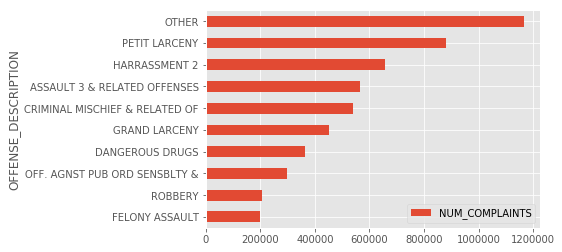

In [25]:
# Plot types of offenses
offense_description_result.sort_values('NUM_COMPLAINTS', ascending = True).plot(kind = 'barh', x = 'OFFENSE_DESCRIPTION', y = 'NUM_COMPLAINTS')

Right, we've seen this before. Petit Larceny takes the cake, followed by Harrassment, Assault, Mischief, and the rest of the gang. Let's move on. Let's take a look at the amount of incidents that were of the different OFFENSE\_LEVELs.

In [46]:
offense_description_result = %read_sql \
SELECT \
    OFFENSE_DESCRIPTION, \
    OFFENSE_LEVEL, \
    OFFENSE_RESULT, \
    COUNT(*) AS NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY \
    OFFENSE_DESCRIPTION, \
    OFFENSE_LEVEL, \
    OFFENSE_RESULT

Query started at 07:44:54 PM UTC; Query executed in 0.26 m

In [55]:
# Prepare dataframe for stacked bar chart
offense_description_result_melted = offense_description_result.pivot_table(
    values = 'NUM_COMPLAINTS',
    index = 'OFFENSE_DESCRIPTION',
    columns = 'OFFENSE_LEVEL',
    aggfunc = np.sum
).fillna(0).reset_index()

In [43]:
# Add back total offenses column
offense_description_result_melted['NUM_COMPLAINTS'] = offense_description_result_melted['FELONY'] +\
    offense_description_result_melted['MISDEMEANOR'] +\
    offense_description_result_melted['VIOLATION']

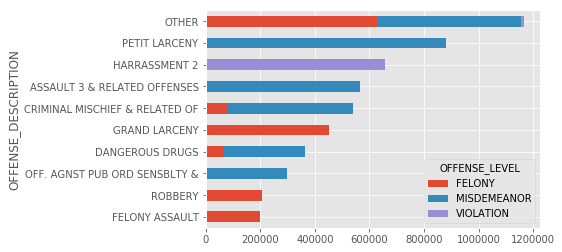

In [45]:
# Plot stacked bar chart
offense_description_result_melted.sort_values('NUM_COMPLAINTS', ascending = True).plot(kind = 'barh', x = 'OFFENSE_DESCRIPTION', y = ['FELONY', 'MISDEMEANOR', 'VIOLATION'], stacked = True)

Here, we can get some more insight into the nature of offenses. Again, violations, misdemeanors, and felonies can be broken out by the following criteria:

>- VIOLATION - Punishable by up to 15 days in jail
- MISDEMEANOR - Punishable by between 15 days and 1 year in jail
- FELONY - Punishable by over 1 year in jail

Harrassment is _**purely violation**_.

Petit Larceny, Assault, and Public Order offenses are _**purely misdemeanor**_.

Mischief and Drugs are _**largely misdemeanor**_ but _**border on felony**_.

Grand Larceny, Robbery, and Assault (Felony) are _**purely felony**_.

The only one I'd like to comment on here is Assault, because it shows up twice. One looks like 3rd degree Assault and less severe (misdemeanor), and one is more severe (felony). The misdemeanor Assault seems to be anything like a punch to the face, whereas the felony Assault can range anything from permenantly disfiguring a body part or putting the victim in substantial risk of death (e.g. gun shot?). Anyways, interesting to see what defines each of these offenses.

The only _**violation**_, seemingly in the entire dataset, is Harrassment. There is a few violations in _**OTHER**_, but that requires a deeper dive which I won't go into right now. Speaking of _**OTHER**_, it's a grouping that I'm trying to think of a better way to represent, but can't right now. It is a mix of misdemeanors and felonies, so it's difficult to profile OTHER. It doesn't help that it's got like 60 categories inside of it and is the largest category right now... Oh well, I don't want any more smaller categories so I'll leave it like this for now.

We also have one more field relating to offenses, let's take a look at whether or not the crime completed. I don't anticipate this will come in handy too much, but worth a look.

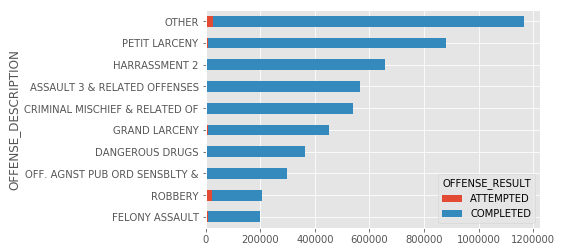

In [60]:
# Prepare dataframe for stacked bar chart
offense_description_result_melted = offense_description_result.pivot_table(
    values = 'NUM_COMPLAINTS',
    index = 'OFFENSE_DESCRIPTION',
    columns = 'OFFENSE_RESULT',
    aggfunc = np.sum
).fillna(0).reset_index()

# Add back total offenses column
offense_description_result_melted['NUM_COMPLAINTS'] = offense_description_result_melted['ATTEMPTED'] +\
    offense_description_result_melted['COMPLETED']
    
# Plot stacked bar chart
offense_description_result_melted.sort_values('NUM_COMPLAINTS', ascending = True).plot(kind = 'barh', x = 'OFFENSE_DESCRIPTION', y = ['ATTEMPTED', 'COMPLETED'], stacked = True)

Most of them are completed. I'm going to leave this for now. Actually, one quick graph just for my own satisfaction, how does OFFENSE\_RESULT look broken down by OFFENSE\_LEVEL?

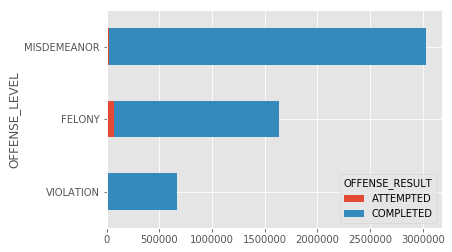

In [62]:
# Prepare dataframe for stacked bar chart
offense_description_result_melted = offense_description_result.pivot_table(
    values = 'NUM_COMPLAINTS',
    index = 'OFFENSE_LEVEL',
    columns = 'OFFENSE_RESULT',
    aggfunc = np.sum
).fillna(0).reset_index()

# Add back total offenses column
offense_description_result_melted['NUM_COMPLAINTS'] = offense_description_result_melted['ATTEMPTED'] +\
    offense_description_result_melted['COMPLETED']
    
# Plot stacked bar chart
offense_description_result_melted.sort_values('NUM_COMPLAINTS', ascending = True).plot(kind = 'barh', x = 'OFFENSE_LEVEL', y = ['ATTEMPTED', 'COMPLETED'], stacked = True)

That's actually what I expected.

<img src="http://www.reactiongifs.com/r/2013/11/vernon.gif" width="400">

No, but in all seriousness, a misdemeanor is probably much easier to pull off than a felony. In any case, though, such a wide majority of the offenses were completed, so OFFENSE\_RESULT will not be a focal point of my analysis.

### Jurisdiction
Pretty easy here, the JURISDICTION column 

In [64]:
jurisdiction_result = %read_sql SELECT \
    JURISDICTION, \
    COUNT(*) AS NUM_COMPLAINTS \
FROM df_filtered \
GROUP BY JURISDICTION

Query started at 09:00:39 PM UTC; Query executed in 0.27 m

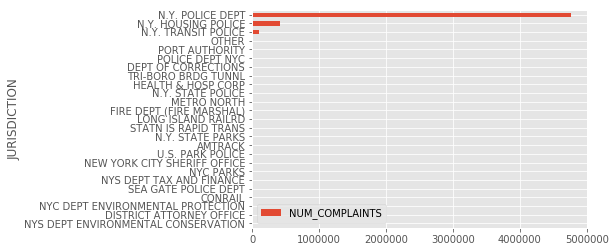

In [67]:
# Plot stacked bar chart
jurisdiction_result.sort_values('NUM_COMPLAINTS', ascending = True).plot(kind = 'barh', x = 'JURISDICTION', y = 'NUM_COMPLAINTS')

Essentially everything comes from a Police Department. Understood. Not much else to see here in my opinion. Next.

### Location
We've got a few location fields. One is definite latitude and longitude, and the other is a description of the environment.